In [3]:
import os
from tqdm import tqdm
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F  
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math,random
import sklearn
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
import utils

C:\Users\loren\anaconda3\envs\dlnn-cuda102\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [58]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
print(torch.cuda.is_available())
print(torch.__version__)

True
1.10.1


In [40]:
# recall this is where the data is coming from
DATA_DIR = '/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small'

# NOTE I DELETED THE TRACK WITH INDEX 297 THAT WAS CAUSING PROBLEMS AND SAVED THE NEW csvfile as trackss.csv
# (the one where I deleted that row)
tracks = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/tracks.csv')
features = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/features.csv')
echonest = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/echonest.csv')

subset = tracks.index[tracks['set', 'subset'] <= 'small']

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

train_ids = tracks.index[tracks['set', 'split'] == 'training']
val_ids = tracks.index[tracks['set', 'split'] == 'validation']
test_ids = tracks.index[tracks['set', 'split'] == 'test']

In [41]:
len(train_ids)

6400

In [42]:
tracks.shape

(8000, 52)

In [43]:
tracks

album                                                              \
         comments        date_created date_released        engineer favorites   
track_id                                                                        
2               0 2008-11-26 01:44:45    2009-01-05             NaN         4   
5               0 2008-11-26 01:44:45    2009-01-05             NaN         4   
10              0 2008-11-26 01:45:08    2008-02-06             NaN         4   
140             1 2008-11-26 01:49:59    2007-05-22             NaN         1   
141             0 2008-11-26 01:49:57    2009-01-16             NaN         1   
...           ...                 ...           ...             ...       ...   
154308          0 2017-03-05 04:57:38    2017-03-05             NaN         0   
154309          0 2017-03-05 04:57:38    2017-03-05             NaN         0   
154413          0 2017-03-07 18:44:11           NaT  Ernie Indradat         0   
154414          0 2017-03-07 18:44:11           NaT  Ernie Indradat         0   
155066          0 2017-03-24 19:40:34    2017-03-24        JBlanked         1   

                                                                            \
             id                                        information listens   
track_id                                                                     
2             1                                            <p></p>    6073   
5             1                                            <p></p>    6073   
10            6                                                NaN   47632   
140          61  <p>Alec K. Redfearn &amp; The Eyesores: Ellen ...    1300   
141          60  <p>A full ensamble of strings, drums, electron...    1304   
...         ...                                                ...     ...   
154308    22780                                                NaN   22334   
154309    22780                                                NaN   22334   
154413    22789  <p>A live performance at WFMU for Dark Night o...    3777   
154414    22789  <p>A live performance at WFMU for Dark Night o...    3777   
155066    22899  <p>Hip Hop, Old School type beat 2017, Trap Mu...    4524   

                                          \
                                producer   
track_id                                   
2                                    NaN   
5                                    NaN   
10                                   NaN   
140       Alec K. Refearn, Rob Pemberton   
141                                  NaN   
...                                  ...   
154308                           Fleslit   
154309                           Fleslit   
154413                     Julie Bennack   
154414                     Julie Bennack   
155066                          JBlanked   

                                                             ...       track  \
                                                       tags  ... information   
track_id                                                     ...               
2                                                        []  ...         NaN   
5                                                        []  ...         NaN   
10                                                       []  ...         NaN   
140                                                      []  ...         NaN   
141                                                      []  ...         NaN   
...                                                     ...  ...         ...   
154308    [fleslit, trap beat free use, trap beat free d...  ...         NaN   
154309    [fleslit, trap beat free use, trap beat free d...  ...         NaN   
154413                                                   []  ...         NaN   
154414                                                   []  ...         NaN   
155066    [old school beats, 2017 free instrumentals, fr...  ...         NaN   

                                 \
         in

__spectrogram computation:__

In [44]:
def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = torchaudio.transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

__creating a list of all the audio paths (just for doing some tests on data later):__

In [45]:
import os
#import librosa
import numpy as np
import matplotlib.pyplot as plt

AUDIO_DIR = "C:/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small"
# here I get the path for each audio file by iterating over the folders
folders = os.listdir(AUDIO_DIR)
audio_paths = []
for folder in folders:
    folder_path = os.path.join(AUDIO_DIR,folder)
    for audio_file in os.listdir(folder_path):
        audio_path = os.path.join(folder_path, audio_file)
        audio_paths.append(audio_path)

# checking that indeed in the small dataset we have 8000 songs
print(len(audio_paths))

7999


**checking out what happens to the first n data points (testing the class) + mel_spec plot + similarity:**

In [46]:
len(audio_paths)

7999

In [57]:
import time
import soundfile
start = time.time()
n = 100
for filepath in audio_paths[:n]:
    sig,sr = torchaudio.load(filepath)
    label = torch.from_numpy(labels_onehot.loc[2].values).float()
    max_len = 44_100//1000 * 30_000
    
    # convert mono to stereo
    if sig.shape[0] != 2:
        sig = torch.cat([sig,sig])

    # standardize sampling rate , since Resample applies to a single channel, we resample one channel at a time :D
    # resample first channel
    if sr != 44100:
        num_channels = sig.shape[0]
        sig1 = torchaudio.transforms.Resample(sr, 44100)(sig[:1,:])
        if (num_channels > 1):
            #resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, 44100)(sig[1:,:])
            sig = torch.cat([sig1,retwo])
        else:
            sig = sig1


    num_rows, sig_len = sig.shape
    
    if (sig_len > max_len):
        # Truncate the signal to the given length
        sig = sig[:,:max_len] 
    elif (sig_len < max_len):
        # length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len  
        # pad with 0s
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))

        sig = torch.cat((pad_begin, sig, pad_end), 1)
    sig.shape
    aud = sig, 44_100
    spec = spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
    
    
    # Create a 2x1 grid of subplots
    #fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (10,4))

    # Plot the spectrogram of the first channel in the first subplot
    #ax[0].imshow(spec[0].numpy(), origin='lower', aspect='auto', cmap='inferno')
    #ax[0].set_title('Channel 1')

    # Plot the spectrogram of the second channel in the second subplot
    #ax[1].imshow(spec[1].numpy(), origin='lower', aspect='auto', cmap='inferno')
   # ax[1].set_title('Channel 2')

    # Show the figure
    #plt.show()
    
    #"similarity" between specs
    #spectrogram_right = spec[0] # The right channel spectrogram
    #spectrogram_left = spec[1] # The left channel spectrogram
    #distance = np.linalg.norm(spectrogram_right - spectrogram_left)
    #print("SIMILARITY:",distance)
elapsed = time.time() - start
print("Elapsed time: ", elapsed)

Elapsed time:  7.61209774017334


In [48]:
print(torchaudio.__version__)

0.10.1


__Plotting one spectrogram__ <br> <br>
- Y-axis = Mel-frequencies
- X-axis = time in terms of audio samples

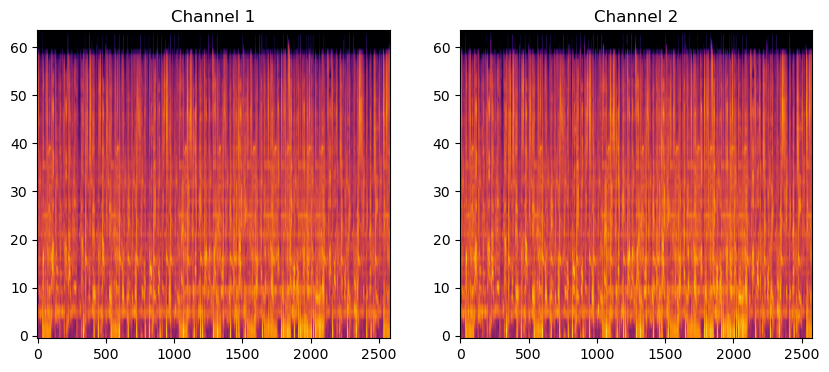

In [17]:
import matplotlib.pyplot as plt

# Create a 2x1 grid of subplots
fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (10,4))

# Plot the spectrogram of the first channel in the first subplot
ax[0].imshow(spec[0].numpy(), origin='lower', aspect='auto', cmap='inferno')
ax[0].set_title('Channel 1')

# Plot the spectrogram of the second channel in the second subplot
ax[1].imshow(spec[1].numpy(), origin='lower', aspect='auto', cmap='inferno')
ax[1].set_title('Channel 2')

# Show the figure
plt.show()

In [18]:
#spec[0] gives the first spec and spec[1] gives the second one
spec.shape

torch.Size([2, 64, 2579])

__similarity between spectrograms:__ <br>
Lower values of the Euclidean distance indicate that the left and right channel are similar, while higher values indicate that they are dissimilar.

In [19]:
# similarity between spectrograms
import numpy as np

# Compute the Euclidean distance between the two spectrograms
spectrogram_right = spec[0] # The right channel spectrogram
spectrogram_left = spec[1] # The left channel spectrogram
distance = np.linalg.norm(spectrogram_right - spectrogram_left)
distance

972.31757

--------------------------------------------------------------------------------------------------------------------------------

__Note : Using _stereo_ signals instead of mono, as for music genre classification this seems to be better, ChatGPT :__ <br>
For music genre classification, using stereo signals may be beneficial as it can provide more information about the audio to the CNN. The spatial characteristics of the sound in a stereo signal can contain information about the instruments used, the arrangement and mixing of the audio, and other features that may be specific to certain genres of music.<br> <br>
The MelSpectrogram function applies a Mel-frequency filter bank to the signal, which maps the linear frequency scale of the signal to a mel-frequency scale, which is more perceptually meaningful for humans, and then applies the Short-time Fourier Transform (STFT) to the signal. The resulting complex numbers are squared to obtain the power spectrum.

In [14]:
# labels contains track id and genre associated to it
labels = tracks['track', 'genre_top']
labels = pd.DataFrame(labels)
labels
# in one-hot vector encoding
labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

In [15]:
df = pd.DataFrame(labels)
genres = df.loc[:, ('track','genre_top')]
unique_genres = genres.unique()
print("Number of unique genres in genre_top:",len(unique_genres))
genres = genres.replace(unique_genres, list(range(len(unique_genres))))
genres = pd.DataFrame(genres)
genres

Number of unique genres in genre_top: 8


,track
,genre_top
track_id,
2,0
5,0
10,1
140,2
141,2
...,...
154308,0
154309,0


In [20]:
#not useful
# torch.tensor(a) gives the label in a pytorch tensor form (a is the label)
torch.tensor(genres.loc[140].values)

tensor([2])

In [21]:
# creating the class for 2DCNN:
class FMA2D(Dataset):
    def __init__(self, data_dir, track_ids, sampling_rate=44_100, max_ms = 30_000):
        self.data_dir = data_dir
        self.filenames = os.listdir(data_dir)
        self.track_ids = track_ids
        self.sampling_rate = sampling_rate
        self.max_ms = max_ms
        
    def __getitem__(self,index):
        tid = self.track_ids[index]
        #load MP3 file
        filepath = utils.get_audio_path(self.data_dir, tid)
        try:
            sig, sr = torchaudio.load(filepath)
        except Exception as e:
            return self.__getitem__(index + 1)
        #label
        label = torch.argmax(torch.from_numpy(labels_onehot.loc[tid].values).float())
        #---------
        #if self.one_hot == True:
        #    label = torch.from_numpy(labels_onehot.loc[tid].values).float()
        #else:
        #label = genres.loc[tid].values
        #-------
        # convert mono to stereo
        if sig.shape[0] != 2:
            sig = torch.cat([sig,sig])
            
        # standardize sampling rate , since Resample applies to a single channel, we resample one channel at a time :D
        # resample first channel
        if sr != self.sampling_rate:
            num_channels = sig.shape[0]
            sig1 = torchaudio.transforms.Resample(sr, self.sampling_rate)(sig[:1,:])
            if (num_channels > 1):
                # resample the second channel and merge both channels
                retwo = torchaudio.transforms.Resample(sr, self.sampling_rate)(sig[1:,:])
                sig = torch.cat([sig1,retwo])
            elif num_channels == 1:
                sig = sig1
                
        # we resize audio samples to have the same length by either extending its duration by padding it with silence, or by
        # truncating it
        num_rows, sig_len = sig.shape
        max_len = 44_100//1000 * self.max_ms
        
        if (sig_len > max_len):
          # Truncate the signal to the given length
          sig = sig[:,:max_len] 
            
        elif (sig_len < max_len):
            # length of paddinf to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len  
            # pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            sig = torch.cat((pad_begin, sig, pad_end), 1)
        
        # now we generate the spectrogram
        aud = sig, self.sampling_rate
        spec = spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None)
        return spec, label
    
    def __len__(self):
        return len(self.track_ids)

--------------------------------------------------------------------------------------------------------------------------------

In [38]:
len(tracks)

8000

In [39]:
# trying that guys code for training and testing
dataset_train = FMA2D(DATA_DIR, train_ids)
print("BRUH",dataset_train[0][0].shape)
print("AHH",dataset_train[0][0])

BRUH torch.Size([2, 64, 2579])
AHH tensor([[[-35.8661, -33.2799, -33.0390,  ...,  24.7497,  25.5375,  26.1847],
         [-35.8661, -31.7082, -12.0041,  ...,  26.5297,  24.9118,  24.5551],
         [-35.8661, -30.6480,   3.0131,  ...,  23.0555,  20.2723,  18.9441],
         ...,
         [-35.8661, -35.8661, -35.8661,  ..., -35.8661, -35.8661, -13.8895],
         [-35.8661, -35.8661, -35.8661,  ..., -35.8661, -35.8661, -14.1670],
         [-35.8661, -35.8661, -35.8661,  ..., -35.8661, -35.8661, -14.2006]],

        [[-35.8661, -31.0524, -21.4482,  ...,  25.0882,  25.9534,  26.5739],
         [-35.8661, -28.5911, -11.5657,  ...,  26.8220,  25.3283,  25.5742],
         [-35.8661, -27.1301,   6.7363,  ...,  23.2990,  21.1279,  19.7239],
         ...,
         [-35.8661, -35.8661, -35.8661,  ..., -35.8661, -35.8661, -10.3530],
         [-35.8661, -35.8661, -35.8661,  ..., -35.8661, -35.8661, -10.4040],
         [-35.8661, -35.8661, -35.8661,  ..., -35.8661, -35.8661, -10.3622]]])


In [25]:
import torch.nn.functional as F
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier(nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [29]:
dataset_train = FMA2D(DATA_DIR, train_ids)
dataset_valid = FMA2D(DATA_DIR, val_ids)
dataset_test = FMA2D(DATA_DIR, test_ids)


# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=False)

# what a data batch along with its labels looks like
for data, label in train_dl:
    print(data.shape,"\n",label.shape)
    print(label)
    break

torch.Size([32, 2, 64, 2579]) 
 torch.Size([32])
tensor([6, 0, 3, 1, 5, 3, 1, 4, 1, 5, 2, 7, 5, 5, 6, 3, 2, 2, 0, 3, 1, 5, 6, 3,
        2, 5, 4, 5, 0, 3, 4, 7])


In [30]:
print("number of samples in the train dataset: ", len(dataset_train))
print("number of samples in the train dataset: ", len(dataset_valid))
print("number of samples in the train dataset: ", len(dataset_test))


number of samples in the train dataset:  6400
number of samples in the train dataset:  800
number of samples in the train dataset:  800


In [31]:
len(train_dl)

200

In [32]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

    number_of_samples = 0
  # Repeat for each epoch
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

    # Repeat for each batch in the training set
        for i, data in enumerate(train_dl):
            number_of_samples += 1
            print("N of samp:",number_of_samples)
            # Get the input features and target labels, and put them on the GPU
            # inputs is one batch of data, labels are the batchs labels
            inputs, labels = data[0].to(device), data[1].to(device)
            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Keep stats for Loss and Accuracy
            running_loss += loss.item()

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

            #if i % 10 == 0:    # print every 10 mini-batches
            #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
        # Print stats at the end of the epoch
        num_batches = len(train_dl)
        avg_loss = running_loss / num_batches
        acc = correct_prediction/total_prediction
        print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

    print('Finished Training')
    
training(myModel, train_dl, num_epochs = 10)

N of samp: 1
N of samp: 2
N of samp: 3
N of samp: 4
N of samp: 5
N of samp: 6
N of samp: 7
N of samp: 8
N of samp: 9
N of samp: 10
N of samp: 11
N of samp: 12
N of samp: 13
N of samp: 14
N of samp: 15
N of samp: 16
N of samp: 17
N of samp: 18
N of samp: 19
N of samp: 20
N of samp: 21
N of samp: 22
N of samp: 23
N of samp: 24
N of samp: 25
N of samp: 26
N of samp: 27
N of samp: 28
N of samp: 29
N of samp: 30
N of samp: 31
N of samp: 32
N of samp: 33
N of samp: 34
N of samp: 35
N of samp: 36
N of samp: 37
N of samp: 38
N of samp: 39
N of samp: 40
N of samp: 41
N of samp: 42
N of samp: 43
N of samp: 44
N of samp: 45
N of samp: 46
N of samp: 47
N of samp: 48
N of samp: 49
N of samp: 50
N of samp: 51
N of samp: 52
N of samp: 53
N of samp: 54
N of samp: 55
N of samp: 56
N of samp: 57
N of samp: 58
N of samp: 59
N of samp: 60
N of samp: 61
N of samp: 62
N of samp: 63
N of samp: 64
N of samp: 65
N of samp: 66
N of samp: 67
N of samp: 68
N of samp: 69
N of samp: 70
N of samp: 71
N of samp: 72
N

N of samp: 550
N of samp: 551
N of samp: 552
N of samp: 553
N of samp: 554
N of samp: 555
N of samp: 556
N of samp: 557
N of samp: 558
N of samp: 559
N of samp: 560
N of samp: 561
N of samp: 562
N of samp: 563
N of samp: 564
N of samp: 565
N of samp: 566
N of samp: 567
N of samp: 568
N of samp: 569
N of samp: 570
N of samp: 571
N of samp: 572
N of samp: 573
N of samp: 574
N of samp: 575
N of samp: 576
N of samp: 577
N of samp: 578
N of samp: 579
N of samp: 580
N of samp: 581
N of samp: 582
N of samp: 583
N of samp: 584
N of samp: 585
N of samp: 586
N of samp: 587
N of samp: 588
N of samp: 589
N of samp: 590
N of samp: 591
N of samp: 592
N of samp: 593
N of samp: 594
N of samp: 595
N of samp: 596
N of samp: 597
N of samp: 598
N of samp: 599
N of samp: 600
Epoch: 2, Loss: 1.58, Accuracy: 0.44
N of samp: 601
N of samp: 602
N of samp: 603
N of samp: 604
N of samp: 605
N of samp: 606
N of samp: 607
N of samp: 608
N of samp: 609
N of samp: 610
N of samp: 611
N of samp: 612
N of samp: 613
N o

N of samp: 1084
N of samp: 1085
N of samp: 1086
N of samp: 1087
N of samp: 1088
N of samp: 1089
N of samp: 1090
N of samp: 1091
N of samp: 1092
N of samp: 1093
N of samp: 1094
N of samp: 1095
N of samp: 1096
N of samp: 1097
N of samp: 1098
N of samp: 1099
N of samp: 1100
N of samp: 1101
N of samp: 1102
N of samp: 1103
N of samp: 1104
N of samp: 1105
N of samp: 1106
N of samp: 1107
N of samp: 1108
N of samp: 1109
N of samp: 1110
N of samp: 1111
N of samp: 1112
N of samp: 1113
N of samp: 1114
N of samp: 1115
N of samp: 1116
N of samp: 1117
N of samp: 1118
N of samp: 1119
N of samp: 1120
N of samp: 1121
N of samp: 1122
N of samp: 1123
N of samp: 1124
N of samp: 1125
N of samp: 1126
N of samp: 1127
N of samp: 1128
N of samp: 1129
N of samp: 1130
N of samp: 1131
N of samp: 1132
N of samp: 1133
N of samp: 1134
N of samp: 1135
N of samp: 1136
N of samp: 1137
N of samp: 1138
N of samp: 1139
N of samp: 1140
N of samp: 1141
N of samp: 1142
N of samp: 1143
N of samp: 1144
N of samp: 1145
N of sam

N of samp: 1592
N of samp: 1593
N of samp: 1594
N of samp: 1595
N of samp: 1596
N of samp: 1597
N of samp: 1598
N of samp: 1599
N of samp: 1600
Epoch: 7, Loss: 1.28, Accuracy: 0.55
N of samp: 1601
N of samp: 1602
N of samp: 1603
N of samp: 1604
N of samp: 1605
N of samp: 1606
N of samp: 1607
N of samp: 1608
N of samp: 1609
N of samp: 1610
N of samp: 1611
N of samp: 1612
N of samp: 1613
N of samp: 1614
N of samp: 1615
N of samp: 1616
N of samp: 1617
N of samp: 1618
N of samp: 1619
N of samp: 1620
N of samp: 1621
N of samp: 1622
N of samp: 1623
N of samp: 1624
N of samp: 1625
N of samp: 1626
N of samp: 1627
N of samp: 1628
N of samp: 1629
N of samp: 1630
N of samp: 1631
N of samp: 1632
N of samp: 1633
N of samp: 1634
N of samp: 1635
N of samp: 1636
N of samp: 1637
N of samp: 1638
N of samp: 1639
N of samp: 1640
N of samp: 1641
N of samp: 1642
N of samp: 1643
N of samp: 1644
N of samp: 1645
N of samp: 1646
N of samp: 1647
N of samp: 1648
N of samp: 1649
N of samp: 1650
N of samp: 1651
N o

In [33]:
model_name = '2DCNNLorenzo_2022-01-23_batchsize_32_epochs_10_opt_Adam_LR_0.001'
torch.save(myModel, model_name + ".pt")

One file is corrupted or smth:
```python
C:/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small\133\133297.mp3 does not exist or is not a regular file
```
I removed it

In [34]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
    correct_prediction = 0
    total_prediction = 0

  # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
            outputs = model(inputs)

      # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
    
    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 0.37, Total items: 800


----

batch size 16 : Accuracy: 0.35, Total items: 800
batch size 32 : Accuracy: 0.37, Total items: 800

## Training

In [37]:
# create a Mp3Dataset from a directory of MP3 files
dataset = FMA2D(DATA_DIR, train_dl)

# create a DataLoader from the FMADataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

    
# create the CNN model
model = AudioClassifier()

# define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

num_epochs = 5
i = 0
running_loss = 0.0
# train the model
for epoch in range(num_epochs):
    for spectrogram, label in dataloader:
        # clear the gradients
        optimizer.zero_grad()

        # forward pass
        output = model(spectrogram)

        loss = loss_fn(output, label)

        # backward pass
        loss.backward()
        optimizer.step()
        # print statistics
        i += 1
        running_loss += loss.item()
        if i % 10 == 9:    # print every 100 samples
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


print('Finished Training')

TypeError: 'DataLoader' object is not subscriptable

## Testing

In [989]:
# create a dataset object for testing
test_dataset = FMA2D(DATA_DIR, test)

# create a data loader to load the dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

# test the model
model.eval()
model.to(device)
correct = 0
total = 0
with torch.no_grad(): # don't need to track, calculate or save the gradients in the model
    for data in test_loader:
        # get the inputs
        audio, labels = data
        # wrap them in a torch Variable
        audio, labels = audio.to(device), labels.to(device)

        # forward + backward + optimize
        outputs = model(audio)
        _, predicted = torch.max(outputs.data, 1)
        labels = torch.argmax(labels, dim=1)
        predicted = torch.argmax(outputs.data, dim=1)
        print(labels)
        print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f"CORRECT #  {correct}")

print('Accuracy of the network on the test samples: %d %%' % (100 * correct / total))

tensor([5, 1, 7, 1, 1, 6, 2, 2, 4, 2, 7, 1, 7, 7, 6, 0])
tensor([3, 1, 5, 5, 2, 2, 5, 2, 2, 2, 7, 5, 7, 2, 5, 5])
CORRECT #  5
tensor([1, 0, 2, 2, 7, 2, 1, 6, 2, 1, 1, 6, 2, 1, 1, 2])
tensor([7, 7, 2, 2, 7, 2, 2, 3, 6, 2, 2, 2, 2, 2, 5, 7])
CORRECT #  10
tensor([2, 2, 2, 6, 1, 1, 2, 2, 7, 0, 7, 2, 5, 1, 2, 2])
tensor([2, 2, 2, 6, 5, 2, 1, 2, 2, 5, 2, 2, 2, 5, 2, 2])
CORRECT #  18
tensor([5, 2, 2, 6, 5, 6, 7, 2, 1, 1, 6, 0, 3, 2, 2, 2])
tensor([3, 5, 1, 2, 5, 2, 2, 7, 2, 2, 3, 1, 5, 2, 2, 2])
CORRECT #  22
tensor([2, 2, 2, 5, 2, 0, 2, 6, 3, 7, 2, 1, 5, 5, 7, 7])
tensor([2, 2, 2, 2, 2, 5, 2, 5, 5, 2, 2, 5, 5, 5, 5, 5])
CORRECT #  30
tensor([2, 6, 2, 2, 5, 2, 7, 6, 1, 1, 7, 7, 6, 7, 2, 1])
tensor([5, 2, 2, 2, 6, 7, 2, 2, 5, 5, 5, 7, 3, 2, 2, 5])
CORRECT #  34
tensor([2, 2, 2, 6, 2, 2, 2, 5, 2, 7, 1, 1, 1, 6, 6, 0])
tensor([7, 7, 5, 7, 6, 2, 7, 5, 6, 7, 2, 5, 2, 3, 7, 5])
CORRECT #  37
tensor([2, 2, 5, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2])
tensor([2, 2, 2, 2, 2, 2, 1, 2, 2, 5, 2, 2, 6, 3

## Remarks on implementations - draft

### There are two types of samples: mono and stereo - we need to convert mono to stereo when feeding the CNN

An audio channel refers to a single track of audio. The number of channels in an audio file determines the number of separate audio tracks that are mixed together to form the final audio.

A mono audio file has a single channel, which means that all the audio is mixed together into one single track. This means that if you play a mono audio file, the same audio will come out of both the left and right speakers (or headphones) and it will sound the same regardless of the stereo or mono setup.

A stereo audio file, on the other hand, has two channels - a left channel and a right channel. These two channels carry separate audio tracks that are mixed together to create the final audio. When played back on a stereo setup, each channel will be played through its corresponding speaker or headphone and this way, the stereo audio creates a sense of space and directionality.

So, for example, a stereo audio recording of a live concert will have different audio captured by different microphone positioned in different positions in the concert hall, and when it is played back, it creates the sense of being there in the concert hall.

It is worth noting that there are also audio file format with more than 2 channels, such as 5.1 or 7.1 surround sound audio.


### Downsampling

 we downsample the audio signals to a lower sample rate to reduce the data size or to simplify the processing of the signal. Downsampling can be useful for tasks such as speech recognition or audio classification, where the lower frequencies of the signal are more important than the higher frequencies.

## Building 2D-CNN with pytorch
### Architecture is the same as nnet1; I'll try to build it here

Architecture :
- 10 layers
    - input layer (128,513)
    - conv layer (128,4,513)
    - Maxpooling layer (2,1)
    - conv layer (128,4,1)
    - Maxpooling (2,1)
    - Convolution (256,4,1)
    - max pool(26,1) and average-pooling(26,1)
    - Dense 300
    - Dense 150
    - Dense 10 (includes the softmax output)

## Data

In [48]:
# all data

DATA_DIR = '/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small'

tracks = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/tracks.csv')
genres = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/genres.csv')
features = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/features.csv')
echonest = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, features.shape, echonest.shape

((106574, 52), (106574, 518), (13129, 249))

## Subset

In [123]:
#tracks now is the small song data set of 8000 songs
subset = tracks.index[tracks['set', 'subset'] <= 'small']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((8000, 52), (8000, 518))

In [124]:
print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])),"\n")

genres = list(LabelEncoder().fit(tracks['track', 'genre_top']).classes_)
#genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres),"\n")
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

6400 training examples, 800 validation examples, 800 testing examples 

Top genres (8): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'] 

All genres (114): [1, 2, 6, 10, 12, 15, 16, 17, 18, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 38, 41, 42, 45, 46, 47, 49, 53, 58, 64, 66, 70, 71, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 167, 171, 172, 174, 177, 180, 181, 182, 183, 184, 185, 186, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 314, 337, 359, 360, 361, 362, 400, 401, 404, 439, 440, 456, 468, 491, 495, 502, 504, 514, 524, 538, 539, 542, 580, 602, 619, 695, 741, 763, 808, 811, 1032, 1060, 1193, 1235]
